In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

Mounted at /gdrive
/gdrive/My Drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
batch_size = 32
IMG_SIZE = (160, 160)

In [4]:
path = "./Esperimento 1/dataset/Train"
#"/content/drive/MyDrive/versione_1.0_nuova"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 6400 files belonging to 2 classes.
Using 5760 files for training.


In [5]:
path = "./Esperimento 1/dataset/Train"
#"/content/drive/MyDrive/versione_1.0_nuova"
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 6400 files belonging to 2 classes.
Using 640 files for validation.


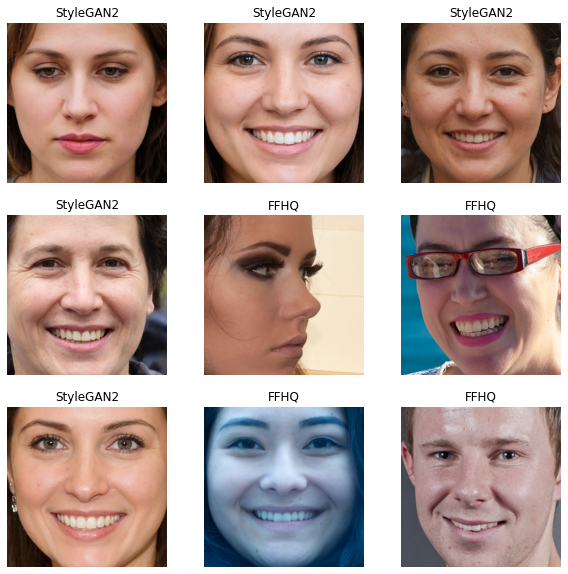

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
print('Numbero di validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Numbero di validation batches: 20


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

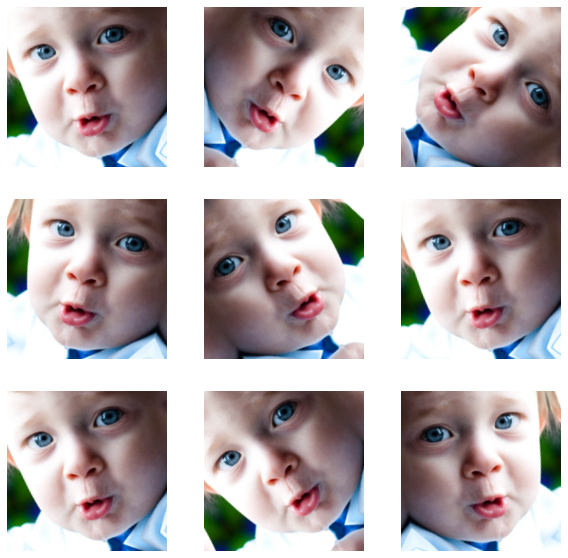

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
#Xception, MobileNetV2, InceptionV3
base_model = tf.keras.applications.ResNet101V2(
    weights="imagenet",  # Caricamento pesi pre-addestrati su ImageNet
    input_shape=(160, 160, 3),
    include_top=False,
)  # Non includere il top

# Freeze the base_model
base_model.trainable = False


inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)  # Applicazione random data augmentation

# Normalizzazione da (0, 255) a (-1, 1)
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

x = norm_layer(x)
norm_layer.set_weights([mean, var])


x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regolazizzazione con dropout
outputs = tf.keras.layers.Dense(1)(x) 
model = tf.keras.Model(inputs, outputs)

model.summary()

171319296/171317808 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 160, 160, 3)       7         
_________________________________________________________________
resnet101v2 (Functional)     (None, 5, 5, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
____________________________________________________________

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("saveBefore_at_{epoch}.h5"),
]

epochs = 10
model.fit(train_dataset, epochs=epochs, callbacks=callbacks, validation_data=validation_dataset)

In [12]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("saveAfter_at_{epoch}.h5"),
]

epochs = 10
model.fit(train_dataset, epochs=epochs, callbacks=callbacks, validation_data=validation_dataset)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 160, 160, 3)       7         
_________________________________________________________________
resnet101v2 (Functional)     (None, 5, 5, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
180/180 [==============================] - 62s 341ms/step - loss: 0.1582 - binary_accuracy: 0.9354 - val_loss: 0.1110 - val_binary_accuracy: 0.9438
Epoch 3/10
180/180 [==============================] - 61s 336ms/step - loss: 0.1194 - binary_accuracy: 0.9519 - val_loss: 0.1276 - val_binary_accuracy: 0.9500
Epoch 4/10
180/180 [==============================] - 60s 333ms/step - loss: 0.0961 - binary_accuracy: 0.9628 - val_loss: 0.0779 - val_binary_accuracy: 0.9688
Epoch 5/10
180/180 [==============================] - 61s 334ms/step - loss: 0.0760 - binary_accuracy: 0.9726 - val_loss: 0.0746 - val_binary_accuracy: 0.9688
Epoch 6/10
180/180 [==============================] - 61s 333ms/step - loss: 0.0752 - binary_accuracy: 0.9696 - val_loss: 0.0555 - val_binary_accuracy: 0.9797
Epoch 7/10
180/180 [==============================] - 61s 335ms/step - loss: 0.0571 - binary_accuracy: 0.9786 - val_loss: 0.0904 - val_binary_accuracy: 0.9594
Epoch 8/10
180/180 [==========================